# Plotting PyPSA results (adapted for the First Run of Bolivia - config.yaml file)

### Adele will check for additional results that can be used


In [1]:
###### algunas cosas cambian si pongo como comentarios en el import de geoviews y hvplot (liberias conflictivas?)

import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd
#import geoviews as gv
#import hvplot.pandas 
import numpy as np
import scipy as sp
import networkx as nx

# plotting stuff
import matplotlib.pyplot as plt

plt.style.use("bmh")
import seaborn as sns  ###
import cartopy.crs as ccrs

sns.set(style="darkgrid")

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared, shapely.wkt

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

import sys

sys.path.append("../")  # to import helpers
from scripts._helpers import sets_path_to_root

sets_path_to_root("pypsa-earth")

max_node_size = 1.0  # maximum size of a node for plotting purposes [used in plots]

This is the repository path:  c:\Users\Lenovo\Desktop\pypsa-earth
Had to go 1 folder(s) up.


In [2]:
# utility function for nice plotting


def normalize_node_size(values, max_node_size=max_node_size):
    return values / values.max() * max_node_size

# Load all networks

In [3]:
# add_electricity_network = os.getcwd() + '/networks/elec.nc'
# n_add_el = pypsa.Network(add_electricity_network)

# clustered_network = os.getcwd() + '/networks/elec_s_20.nc'
# n_cluster = pypsa.Network(clustered_network)



#Se carga el documento (o la direccion/path del mismo) a una variable (solved_network)

solved_network = os.getcwd() + "/results/networks/elec_s_10_ec_lcopt_Co2L-6H.nc"

#Se cargan los resultados de la optimizacion del problema segun las caracteristicas definidas para el modelo en n_solve con la funcion (operador?) Network de pypsa

n_solve = pypsa.Network(solved_network)

INFO:pypsa.io:Imported network elec_s_10_ec_lcopt_Co2L-6H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


# Solved network

In [4]:
n = n_solve

In [5]:
# ".global_constraints" muestra las restricciones consideradas para el modelo (en el config.yaml solo se tomo en cuenta el limite de emisiones) tonCO2/year

n.global_constraints

,sense,constant,mu,type,investment_period,carrier_attribute
GlobalConstraint,,,,,,
CO2Limit,<=,77500000.0,7.623424e-07,primary_energy,NaN,co2_emissions


In [6]:
#Calculo del precio promedio de energia promedio en la red (costo total de operacion)= ".objective" /  (sumatoria de las cargas variables en el tiempo)
# EURO/MWh

##### check why the value does not appear 
#   - It seems that while the model run before, due to restrictions on simulation, proper solving wasn't possible (by increasing tolerances of the solver the model gets actual results)


n.objective

2221925037.840623

### Spatial temporal resolution

(<matplotlib.collections.PatchCollection at 0x2416169f3d0>,
 <matplotlib.collections.LineCollection at 0x241617726e0>)

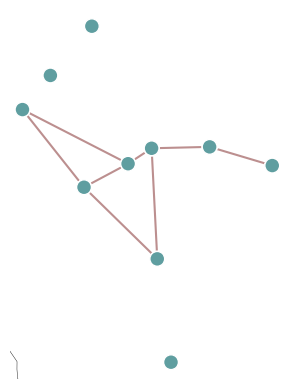

In [7]:
#Resultado grafico de la red electrica ideal (lineas verdes representan expansiones de la red)

#####beacuase all buses are not connected it might be that the problem is not fully solved 
# - Lines used in the model don't consider newer power lines (data bases were not apdated)
# - This is proved by comparing raw lines (all available lines in OSM) and clean lines (processed lines to be used in the model)
# - A linker is required to include new/additional data into the "all_clean_lines.geojson"


n.plot()

In [8]:
#Se muestra el tamaño de la resolucion temporal del modelo - timesteps 
# - Currently the system is working with a toy version of Bolivia to allow faster solving times (6h time aggregation and a little over 5 months acoording the rules in the config.yaml file) 
# - A more complete model should be run eventually with different conditions (higher time resolution) or methods like tsam (https://tsam.readthedocs.io/en/latest/mathematicalBackgroundDoc.html)
#  

len(n.snapshots)

624

### Overview components

In [9]:
#Imprimir la lista de componentes considerados en el dataframe creado

for c in n.iterate_components(list(n.components.keys())[2:]):
    print("Component '{}' has {} entries".format(c.name, len(c.df)))

Component 'Bus' has 30 entries
Component 'Carrier' has 16 entries
Component 'GlobalConstraint' has 1 entries
Component 'Line' has 8 entries
Component 'LineType' has 34 entries
Component 'TransformerType' has 14 entries
Component 'Link' has 40 entries
Component 'Load' has 10 entries
Component 'Generator' has 41 entries
Component 'StorageUnit' has 5 entries
Component 'Store' has 20 entries


### Energy balance

In [10]:
# ".stores_t" hace referencia a la energia que se puede almacenar en un bus (se usa para definir otras tecnologias como storage)
# - https://pypsa.readthedocs.io/en/latest/components.html#store

n.stores_t.p.sum()

Store
BO 0 H2        -2.081668e-17
BO 1 H2        -4.857226e-17
BO 2 H2         6.245005e-17
BO 3 H2        -1.387779e-17
BO 4 H2         0.000000e+00
BO 5 H2         0.000000e+00
BO 6 H2        -3.469447e-17
BO 7 H2         7.632783e-17
BO 8 H2         0.000000e+00
BO 9 H2         0.000000e+00
BO 0 battery    8.673617e-19
BO 1 battery    6.938894e-18
BO 2 battery    0.000000e+00
BO 3 battery   -2.602085e-18
BO 4 battery    0.000000e+00
BO 5 battery    0.000000e+00
BO 6 battery    5.204170e-18
BO 7 battery   -7.806256e-18
BO 8 battery    0.000000e+00
BO 9 battery    0.000000e+00
dtype: float64

In [11]:
# se imprimen todos los generadores considerados en el modelo

##### check if loadshedding is being used in the config.yaml file, at the solving section 
# - load shedding is represented in the model by the inclution on additional "load" generation/generators 


n.generators

print(type(n.generators))
print(n.generators.columns)
n.generators

<class 'pandas.core.frame.DataFrame'>
Index(['p_nom_max', 'weight', 'p_nom', 'capital_cost', 'efficiency',
       'p_nom_min', 'marginal_cost', 'bus', 'p_nom_extendable', 'carrier',
       'control', 'p_nom_opt', 'sign', 'build_year', 'min_up_time',
       'min_down_time', 'up_time_before', 'down_time_before', 'type',
       'p_min_pu', 'p_max_pu', 'p_set', 'q_set', 'lifetime', 'committable',
       'start_up_cost', 'shut_down_cost', 'ramp_limit_up', 'ramp_limit_down',
       'ramp_limit_start_up', 'ramp_limit_shut_down'],
      dtype='object')


,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,bus,p_nom_extendable,carrier,control,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,type,p_min_pu,p_max_pu,p_set,q_set,lifetime,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BO 0 OCGT,inf,0.000000,3.535638e+02,47234.561404,0.390,353.563766,58.393835,BO 0,True,OCGT,Slack,3.535732e+02,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 biomass,inf,0.000000,7.229000e+01,278015.359506,0.468,72.290000,14.967433,BO 0,False,biomass,,7.229000e+01,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 onwind,5.872036e+05,59888.246048,1.218925e+01,109295.569252,1.000,12.189249,0.025173,BO 0,False,onwind,,1.218925e+01,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 solar,2.221573e+05,30992.064349,1.126932e+01,50855.958267,1.000,11.269319,0.019092,BO 0,False,solar,,1.126932e+01,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 onwind,1.982455e+05,5754.541306,1.040536e+00,109295.569252,1.000,1.040536,0.025993,BO 1,False,onwind,,1.040536e+00,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 solar,3.039954e+05,61268.474745,2.266456e+01,50855.958267,1.000,22.664558,0.019101,BO 1,False,solar,,2.266456e+01,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 2 OCGT,inf,0.000000,1.207441e+02,47234.561404,0.390,120.744063,58.394349,BO 2,True,OCGT,,1.207520e+02,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 2 oil,inf,0.000000,3.399651e+01,38234.561404,0.393,33.996513,130.237294,BO 2,False,oil,,3.399651e+01,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 2 onwind,6.009534e+05,26703.715966,6.511923e+00,109295.569252,1.000,6.511923,0.025097,BO 2,False,onwind,,6.511923e+00,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0


In [12]:
#Imprimir solo los generadores de Bolivia

########(this is only necessary if several countries are studied at the same time

idx = ['BO' in x for x in n.generators.index]
n.generators.loc[idx,:]

,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,bus,p_nom_extendable,carrier,control,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,type,p_min_pu,p_max_pu,p_set,q_set,lifetime,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BO 0 OCGT,inf,0.000000,3.535638e+02,47234.561404,0.390,353.563766,58.393835,BO 0,True,OCGT,Slack,3.535732e+02,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 biomass,inf,0.000000,7.229000e+01,278015.359506,0.468,72.290000,14.967433,BO 0,False,biomass,,7.229000e+01,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 onwind,5.872036e+05,59888.246048,1.218925e+01,109295.569252,1.000,12.189249,0.025173,BO 0,False,onwind,,1.218925e+01,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 solar,2.221573e+05,30992.064349,1.126932e+01,50855.958267,1.000,11.269319,0.019092,BO 0,False,solar,,1.126932e+01,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 onwind,1.982455e+05,5754.541306,1.040536e+00,109295.569252,1.000,1.040536,0.025993,BO 1,False,onwind,,1.040536e+00,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 solar,3.039954e+05,61268.474745,2.266456e+01,50855.958267,1.000,22.664558,0.019101,BO 1,False,solar,,2.266456e+01,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 2 OCGT,inf,0.000000,1.207441e+02,47234.561404,0.390,120.744063,58.394349,BO 2,True,OCGT,,1.207520e+02,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 2 oil,inf,0.000000,3.399651e+01,38234.561404,0.393,33.996513,130.237294,BO 2,False,oil,,3.399651e+01,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 2 onwind,6.009534e+05,26703.715966,6.511923e+00,109295.569252,1.000,6.511923,0.025097,BO 2,False,onwind,,6.511923e+00,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0


In [13]:
#Imprimir la suma de potencias nominales (2013) de los generadores de Bolivia

####### Data was not yet updated and therefore a big difference between real capacities in 2020 (largely oversized) and optimized installed capacities (relatively low changes)
# - To change this, additional plants have to be added to better represent the system

idx = ['BO' in x for x in n.generators.index]
n.generators.loc[idx,:].p_nom.sum()

10000001526.468107

In [14]:
# Difference between total load and generation
# losses = n.stores_t

n.generators_t.p.sum().sum() - n.loads_t.p.sum().sum()  # - substract storage losses


156459102.36640614

### Total installed generator capacity

In [24]:
gen_cap = n.generators.groupby(["carrier"]).sum()
gen_cap

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_27344\2958603594.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gen_cap = n.generators.groupby(["carrier"]).sum()


,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,p_nom_extendable,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,p_min_pu,p_max_pu,p_set,q_set,lifetime,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
carrier,,,,,,,,,,,,,,,,,,,,,,,,,,,
OCGT,NaN,0.000000,9.143409e+02,2.361728e+05,1.950,914.340881,291.969349,5,9.143805e+02,5.00,0,0,0,5,0,0.0,5.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,5.0,5.0
biomass,NaN,0.000000,7.723000e+01,5.560307e+05,0.936,77.230000,29.934547,0,7.723000e+01,2.00,0,0,0,2,0,0.0,2.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,2.0,2.0
load,NaN,0.000000,1.000000e+10,0.000000e+00,10.000,0.000000,10.102498,0,1.000000e+10,0.01,0,0,0,10,0,0.0,10.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,10.0,10.0
oil,NaN,0.000000,4.573651e+01,7.646912e+04,0.786,45.736513,260.473081,0,4.573651e+01,2.00,0,0,0,2,0,0.0,2.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,2.0,2.0
onwind,2.376047e+06,124486.370505,2.596471e+01,1.092956e+06,10.000,25.964709,0.252814,0,2.596471e+01,10.00,0,0,0,10,0,0.0,10.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,10.0,10.0
ror,NaN,344.006279,3.440063e+02,5.418814e+05,1.800,0.000000,0.019754,0,3.440063e+02,2.00,0,0,0,2,0,0.0,2.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,2.0,2.0
solar,1.869632e+06,324318.258522,1.191897e+02,5.085596e+05,10.000,119.189726,0.195833,0,1.191897e+02,10.00,0,0,0,10,0,0.0,10.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,10.0,10.0


In [16]:
n.stores_t.p.head()

Store,BO 0 H2,BO 1 H2,BO 2 H2,BO 3 H2,BO 4 H2,BO 5 H2,BO 6 H2,BO 7 H2,BO 8 H2,BO 9 H2,BO 0 battery,BO 1 battery,BO 2 battery,BO 3 battery,BO 4 battery,BO 5 battery,BO 6 battery,BO 7 battery,BO 8 battery,BO 9 battery
snapshot,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.003876,0.004059,0.004007,0.004238,0.000015,0.003796,0.004116,0.004043,-0.000011,-1.190099e-07,0.000209,0.000304,0.000271,0.000332,0.000033,0.000219,0.000258,0.000267,-0.000047,-0.000013
2013-01-01 06:00:00,-0.003982,-0.004318,-0.003698,-0.004445,-0.000038,-0.004554,-0.003863,-0.003968,-0.000011,-6.593688e-06,-0.000599,-0.000725,-0.000514,-0.000744,-0.000210,-0.000701,-0.000623,-0.000661,-0.000053,-0.000081
2013-01-01 12:00:00,0.007236,0.007330,0.006605,0.007422,-0.000013,0.008029,0.007179,0.006886,0.000011,4.416415e-06,0.000538,0.000588,0.000464,0.000589,-0.000006,0.000593,0.000543,0.000557,0.000042,0.000037
2013-01-01 18:00:00,-0.008948,-0.008575,-0.009168,-0.008584,-0.000004,-0.008828,-0.008909,-0.008863,0.000012,4.279037e-06,-0.000086,-0.000047,-0.000257,-0.000023,0.000040,-0.000002,-0.000080,-0.000061,0.000054,0.000038
2013-01-02 00:00:00,0.003635,0.003798,0.004141,0.003591,-0.000040,0.003362,0.003776,0.003972,-0.000010,-3.284223e-07,0.000177,0.000160,0.000352,0.000129,-0.000092,0.000100,0.000172,0.000160,-0.000046,-0.000003


<AxesSubplot:xlabel='snapshot'>

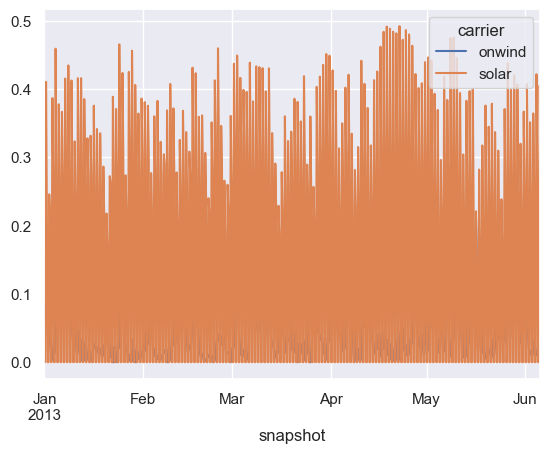

In [17]:
n.generators_t.p_max_pu.groupby(n.generators.carrier, axis=1).mean().plot()

In [18]:
# If 0, all renewable capacity potential is used
n.generators.p_nom_max.sum() - n.generators.p_nom_opt.sum()

inf

In [19]:
n.loads_t.p.sum().sum()

802471.0199702531

In [20]:
n.generators_t.p.sum().sum()

157261573.38637638

In [21]:
#### pq la multiplicacion?

n.generators.iloc[:, :].groupby(["bus", "carrier"]).p_nom.sum() * 0.0000003

bus   carrier
BO 0  OCGT       1.060691e-04
      biomass    2.168700e-05
      load       3.000000e+02
      onwind     3.656775e-06
      solar      3.380796e-06
BO 1  load       3.000000e+02
      onwind     3.121608e-07
      solar      6.799367e-06
BO 2  OCGT       3.622322e-05
      load       3.000000e+02
      oil        1.019895e-05
      onwind     1.953577e-06
      solar      1.502944e-05
BO 3  OCGT       2.167464e-05
      load       3.000000e+02
      onwind     6.559479e-08
      ror        7.821645e-05
      solar      3.271149e-06
BO 4  biomass    1.482000e-06
      load       3.000000e+02
      oil        3.522000e-06
      onwind     1.681481e-06
      solar      5.814411e-06
BO 5  OCGT       4.495021e-05
      load       3.000000e+02
      onwind     0.000000e+00
      solar      3.880421e-07
BO 6  OCGT       6.538507e-05
      load       3.000000e+02
      onwind     7.859891e-08
      solar      2.834468e-07
BO 7  load       3.000000e+02
      onwind     4.122531e

AssertionError: Colors not defined for all elements in the second MultiIndex level of bus_sizes, please make sure that all the elements are included in bus_colors or in n.carriers.color

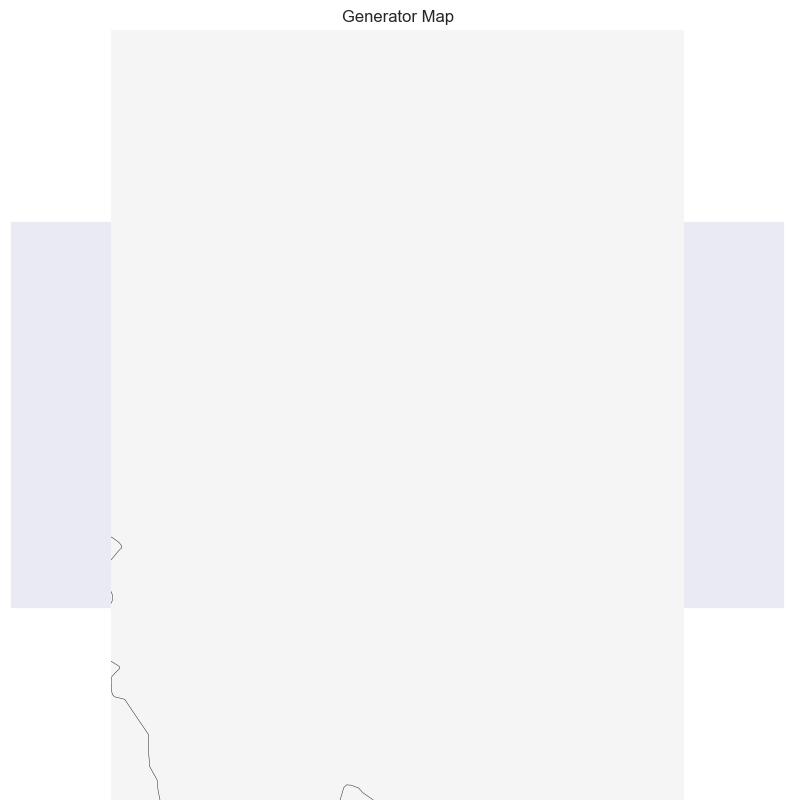

In [22]:
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

# loading = (n3.lines_t.p0.abs().mean().sort_index() / (n3.lines.s_nom_opt*n.lines.s_max_pu).sort_index()).fillna(0.)

n.plot(
    margin=0.1,
    ax=None,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=normalize_node_size(
        n.generators.iloc[:, :].groupby(["bus", "carrier"]).p_nom_opt.sum()),
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 3e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="Generator Map",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.axis("off");

### Demand

In [ ]:
print(type(n.generators.iloc[:, :].groupby(["bus"]).p_nom_opt.sum()))

print(n.generators.iloc[:, :].groupby(["bus"]).p_nom_opt.sum())

<class 'pandas.core.series.Series'>
bus
BO 0    1.000000e+09
BO 1    1.000000e+09
BO 2    1.000000e+09
BO 3    1.000000e+09
BO 4    1.000003e+09
BO 5    1.000000e+09
BO 6    1.000002e+09
BO 7    1.000000e+09
BO 8    1.000000e+09
BO 9    1.000000e+09
Name: p_nom_opt, dtype: float64


<AxesSubplot:xlabel='snapshot'>

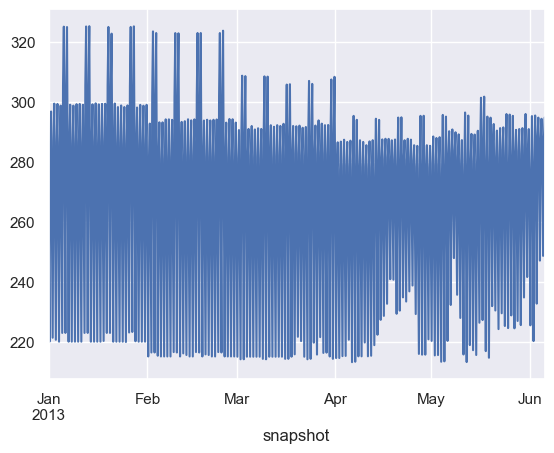

In [ ]:
n.loads_t.p_set.loc["2013-01-01":"2013-06-06","BO 0"].plot()

In [ ]:
type(n.loads_t.p_set.sum())

pandas.core.series.Series

In [ ]:
a = n.loads_t.p_set.sum().rename("load").rename_axis("bus")
a.rename("load", inplace=True)
a.rename_axis("bus", inplace=True)
a

bus
BO 0    165760.688502
BO 1     81159.348527
BO 2    191724.571497
BO 3     66017.013065
BO 4    149443.435993
BO 5     48288.153868
BO 6     73000.693259
BO 7      1794.942286
BO 8     18036.350625
BO 9      7245.822349
Name: load, dtype: float64

In [ ]:
n.generators.iloc[:, :].groupby(["bus"]).p_nom_opt.sum()

###### potencia maxima?
#n.generators.iloc[:, :].groupby(["bus"]).p_max_pu.sum()

bus
BO 0    1.000000e+09
BO 1    1.000000e+09
BO 2    1.000000e+09
BO 3    1.000000e+09
BO 4    1.000003e+09
BO 5    1.000000e+09
BO 6    1.000002e+09
BO 7    1.000000e+09
BO 8    1.000000e+09
BO 9    1.000000e+09
Name: p_nom_opt, dtype: float64

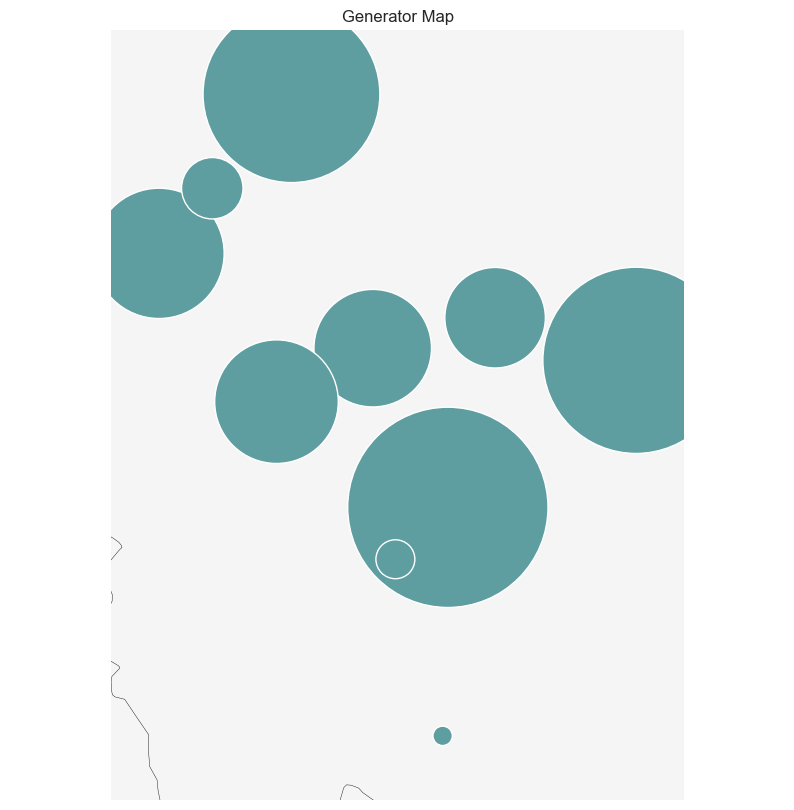

In [ ]:
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

# loading = (n3.lines_t.p0.abs().mean().sort_index() / (n3.lines.s_nom_opt*n.lines.s_max_pu).sort_index()).fillna(0.)

n.plot(
    margin=0.1,
    ax=None,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=normalize_node_size(
        n.loads_t.p_set.sum().rename("load").rename_axis("bus")
    ),  # n.loads_t.p_set.sum().rename("load").rename_axis("bus")*.0000003,
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 3000000000e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="Generator Map",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.axis("off");

In [ ]:
# backup
gen_serie = n.generators.iloc[:, :].groupby(["bus", "carrier"]).p_nom_opt.sum()
load_serie = n.loads_t.p_set.sum().rename("load").rename_axis("bus")

load_serie = pd.Series(
    load_serie.values,
    index=pd.MultiIndex.from_tuples([(id, "AC load") for id in load_serie.index]),
)

tot_serie = pd.concat([gen_serie, load_serie])  # .groupby(['bus', 'carrier']).sum()

pd.concat([gen_serie, load_serie])

bus   carrier
BO 0  OCGT       3.535640e+02
      load       1.000000e+09
      onwind     1.218930e+01
      solar      1.126941e+01
BO 1  OCGT       7.224898e+01
      load       1.000000e+09
      onwind     2.186599e-01
      ror        2.607215e+02
      solar      1.090423e+01
BO 2  OCGT       1.078072e+02
      load       1.000000e+09
      oil        3.399651e+01
      onwind     6.511956e+00
      solar      4.635814e+01
BO 3  OCGT       1.498342e+02
      load       1.000000e+09
      onwind     3.850991e-05
      ror        8.328479e+01
      solar      3.159106e+00
BO 4  load       1.000000e+09
      onwind     5.604957e+00
      solar      3.059832e+03
BO 5  OCGT       2.179503e+02
      load       1.000000e+09
      onwind     3.995894e-01
      solar      1.303728e+00
BO 6  load       1.000000e+09
      onwind     1.040557e+00
      solar      1.637178e+03
BO 7  load       1.000000e+09
      onwind     6.234531e-05
      solar      2.688550e+01
BO 8  load       1.000000e

### Plot of Average Marginal Price

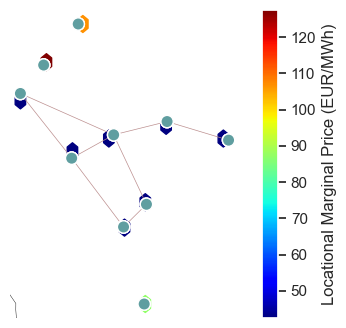

In [ ]:
now = n.snapshots[4]  ##one specific time

fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(6, 4)

n.plot(ax=ax, line_widths=pd.Series(0.5, n.lines.index))
plt.hexbin(
    n.buses.x,
    n.buses.y,
    gridsize=20,
    # C=n.buses_t.marginal_price.loc[now], #at one time (previous set up by scigrid)
    C=n.buses_t.marginal_price.sum()
    / len(n.snapshots[:]),  # Marginal price averaged over the whole year (My version)
    # - shows in which regions electricity will be cheap and where el. intensive companies should be placed.
    cmap=plt.cm.jet,
)

# for some reason the colorbar only works with graphs plt.plot
# and must be attached plt.colorbar

cb = plt.colorbar()
cb.set_label("Locational Marginal Price (EUR/MWh)")

### Storage

<AxesSubplot:xlabel='snapshot'>

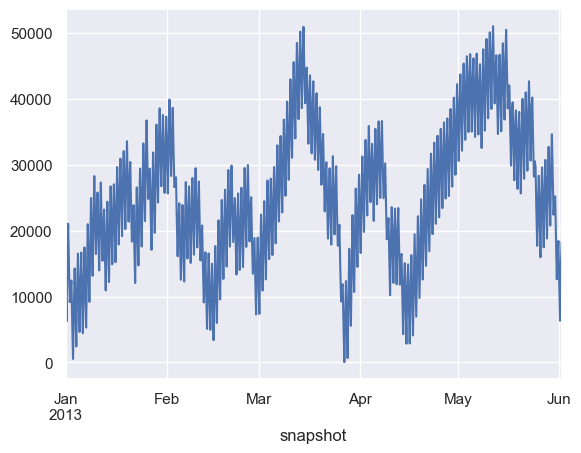

In [ ]:
n.stores_t.e.loc["2013-01-01":"2013-06-01"].sum(axis=1).plot()

In [ ]:
n.links.iloc[:].groupby(["carrier"]).p_nom_opt.sum()

carrier
H2 electrolysis       779.227504
H2 fuel cell          482.534463
battery charger         0.017229
battery discharger      0.019144
Name: p_nom_opt, dtype: float64